In [29]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [30]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')

In [31]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [32]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025

fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [33]:

zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm)

/home/spencerj/oceanmodes/oceanmodes/baroclinic.py:202: RuntimeWarning: invalid value encountered in power
  Rd = (-w)**-0.5 / np.absolute(f0)


In [34]:
eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

eta_merged = eta_merged.isel(time=slice(1,110))

eta_merged = eta_merged.drop_vars('time')

In [35]:
def lanczos(x, a):
    return np.sinc(x/a)

In [36]:
window_width=20
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])

In [37]:
nofiles=49
eta_eul_filtered = eta_merged.Eta.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
eta_eul_filtered = eta_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [39]:
fnames = sorted(glob(f'/swot/SUM01/spencer/36hr_timeseries/*.zarr'))
nofiles = len(fnames)
for fileno in range(0,49):#nofiles
        print('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where(ds.u!=-999)
        window_width=20
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_eta = ds.eta.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        eta_piece = windowed_eta.sel(time=0).isel(z0=3)
        eta_piece2 = ds.eta.sel(time=0).isel(z0=3)
        eta_piece["time"] = fileno*3600
        eta_piece2["time"] = fileno*3600
        if fileno==0:
            eta_filtered = eta_piece
            eta_unfiltered = eta_piece2
        else:
            eta_filtered = xr.concat([eta_filtered,eta_piece],dim='time')
            eta_unfiltered = xr.concat([eta_unfiltered,eta_piece2],dim='time')

/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6192.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6336.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6480.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6624.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6768.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6912.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7056.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7200.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7344.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7488.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7632.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7776.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7920.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8064.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8208.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8352.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_84

In [48]:
with ProgressBar():
    etahat_un = xrft.power_spectrum(eta_unfiltered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  1min 28.1s


In [49]:
with ProgressBar():
    etahat2 = xrft.power_spectrum(eta_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                               ).compute()#, detrend='linear'

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  2min 17.1s


In [50]:
#spectrum_filtered_eul
with ProgressBar():
    etahat2eul = xrft.power_spectrum(eta_eul_filtered.chunk({'time':-1}),dim=['time'], window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 13.0s


In [51]:
spec0 = int((etahat2['freq_time'].size-1)/2)

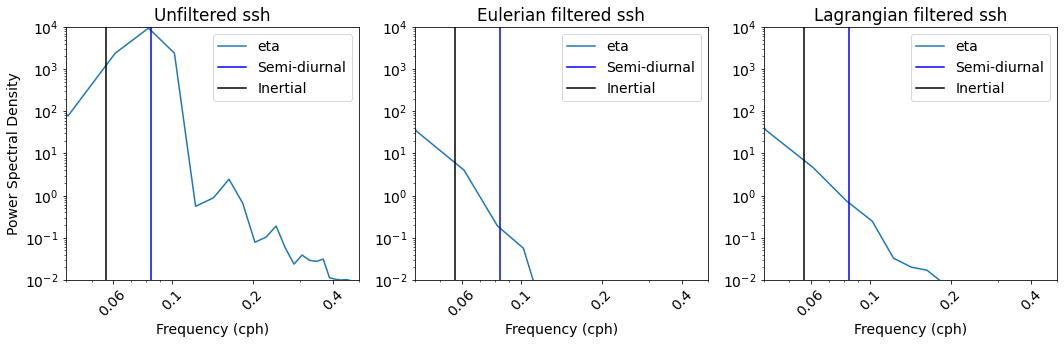

In [52]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(etahat_un.freq_time[spec0:]*3600,etahat_un.mean(['x0','y0'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
plt.ylabel('Power Spectral Density')


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered ssh')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(etahat2eul.freq_time[spec0:]*3600,etahat2eul.mean(['i','j'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered ssh')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')


plt.subplot(133)
plt.plot(etahat2.freq_time[spec0:]*3600,etahat2.mean(['x0','y0'])[spec0:],label='eta')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered ssh')
plt.ylim(10**-2,10**4)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('eta_filt_unfilt.png')

In [53]:
eta_eul_filtered = eta_eul_filtered.assign_coords(x0=("i", etahat2.x0.values)).swap_dims({"i": "x0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(y0=("j", etahat2.y0.values)).swap_dims({"j": "y0"})

In [54]:
lons, lats = np.meshgrid(eta_filtered.x0.values, eta_filtered.y0.values)

In [55]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [56]:
eta_eul_resampled = ufunc_resample(eta_eul_filtered.load())
eta_resampled = ufunc_resample(eta_filtered.load())
eta_resampled_unfilt = ufunc_resample(eta_unfiltered.load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [57]:
eta_eul_resampled = eta_eul_resampled.assign_coords(x1=("x1", eta_eul_resampled.x1.values)).assign_coords(y1=("y1", eta_eul_resampled.y1.values))
eta_resampled = eta_resampled.assign_coords(x1=("x1", eta_resampled.x1.values)).assign_coords(y1=("y1", eta_resampled.y1.values))
eta_resampled_unfilt = eta_resampled_unfilt.assign_coords(x1=("x1", eta_resampled_unfilt.x1.values)).assign_coords(y1=("y1", eta_resampled_unfilt.y1.values))


In [58]:
with ProgressBar():
    eta2_ps = xrft.power_spectrum(eta_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [59]:
with ProgressBar():
    eta2_ps_unfilt = xrft.power_spectrum(eta_resampled_unfilt, dim=['x1','y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [60]:
with ProgressBar():
    eta2_ps_eul = xrft.power_spectrum(eta_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [61]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [62]:
ps_iso = iso_spec(eta2_ps)
ps_iso_unfilt = iso_spec(eta2_ps_unfilt)
ps_iso_eul = iso_spec(eta2_ps_eul)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [63]:
kr    = ps_iso.kr
omegaM = np.nan*np.ones([kr.shape[0], 6])
for i in range(1,6):
    
    Kdi = 1/RdS[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:47: UserWarning: Log scale: values of z <= 0 have been masked


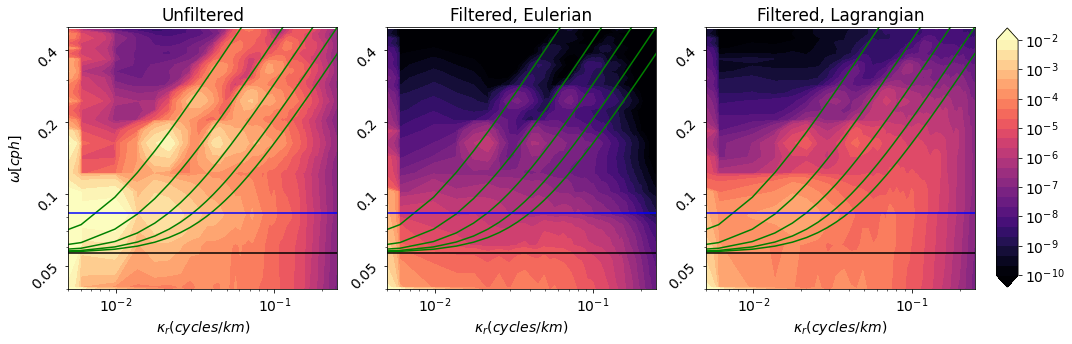

In [68]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-10,-2,25)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Eulerian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Lagrangian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)



fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)


fig.savefig('wavenumber_freq_eta.png')